# Generating dataset
### Output: NumPy array file of dataset

#### Things to do:
##### 1. Convert grayscale to B&W and increase contrast
##### 2. Invert image, get bounding box, and display
##### 3. Crop the character inside bounding box
##### 4. Enhance image (optional)
##### 5. Resize and Center
##### 6. Generate variations of each character using diacritic
##### 7. Save the result in numpy binary format
___

## Import packages

In [1]:
#import sys
#!{sys.executable} -m pip install opencv-python

In [2]:
# Import statements
%matplotlib inline

import cv2
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time
import random

## Load the data

In [3]:
# Set the path of the characters
cropped_folder_path = 'cropped'
character_folder_list = [x for x in os.listdir(cropped_folder_path) if x != '.DS_Store']
character_list = sorted(character_folder_list)
print(character_list)


# Iterate through folder and get all files
# cropped_scanned_list = glob.glob(f'{cropped_folder_path}/*/*.png')
# print(len(cropped_scanned_list))
# print(cropped_scanned_list)

# Since images are complete and ordered, we can generate the filenames
# However, this will not work if user deleted a file
images_list = {}

for character in character_list:
    character_path = f'{cropped_folder_path}/{character}'
    images = []
    
    count = 0
    for path in os.listdir(character_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(character_path, path)):
            count += 1
#     print(f'File count of {character}:', count)
    
    for i in range(count-1):
        images.append(f'{character}/{character}-{i}.png')
    
    images_list[character] = images
    
# print(images_list)

['A', 'BA', 'DA', 'E:I', 'GA', 'HA', 'KA', 'LA', 'MA', 'NA', 'NGA', 'O:U', 'PA', 'RA', 'SA', 'TA', 'WA', 'YA']


In [4]:
# Replace E:I and O:U to E/I and O/U labels
new_character_list = character_list.copy()
for i in range(len(new_character_list)):
    if new_character_list[i] == 'E:I':
        new_character_list[i] = 'E/I'
    if new_character_list[i] == 'O:U':
        new_character_list[i] = 'O/U'

In [5]:
new_character_list

['A',
 'BA',
 'DA',
 'E/I',
 'GA',
 'HA',
 'KA',
 'LA',
 'MA',
 'NA',
 'NGA',
 'O/U',
 'PA',
 'RA',
 'SA',
 'TA',
 'WA',
 'YA']

In [6]:
# Helper function to print details of an image
def show(img, figsize=(8, 4), title=None):
    print(f'Image details')
    print(f'Format {image.format}')
    print(f'Size {image.size}')
    print(f'Mode {image.mode}')
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='Greys')
    if title:
        plt.title(title)
    plt.show()

## Main process

### Set constants

In [7]:
# Constants
NEW_SIZE = 80
VOWELS = ['A', 'E:I', 'O:U']

___

### Set dictionaries

In [8]:
# List to store the resized and centered samples
resized_samples_list = {}

# List to store the variations of each character
variations_samples_list = {}

___

### Set functions

In [9]:
# Helper function to resize and center an image
def resize_and_center(sample):
    delta_w = NEW_SIZE - crop.size[0]
    delta_h = NEW_SIZE - crop.size[1]
    # Left Top Right Bottom
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(crop, padding)

In [10]:
# Main function to get the character from image
def get_character(image, contrast=3, invert=True):
    denoised = image.filter(ImageFilter.MedianFilter())
    
    # 1. Convert grayscale to B&W and increase contrast
    bw_image = denoised.convert(mode='L') #L is 8-bit black-and-white image mode
    bw_image = ImageEnhance.Contrast(bw_image).enhance(contrast)
    
    if invert:
        # 2. Invert image, get bounding box, and display
        inv_sample = ImageOps.invert(bw_image)
        bbox = inv_sample.getbbox()

        # 3. Crop the character inside bounding box
        crop = inv_sample.crop(bbox)
    else:
        bbox = bw_image.getbbox()
        crop = bw_image.crop(bbox)
    
    return crop

In [11]:
# Converts the image to binary and removes background noise for better crop
def enhance(img):
    # Convert image to numpy array
    na = np.array(img)
    
    # Get low (say 1%) and high (say 95%) percentiles
    loPct, hiPct = 1.0, 95.0
    loVal, hiVal = np.percentile(na, [loPct, hiPct])
    
    # Scale image pixels from range loVal..hiVal to range 0..255
    res = ((na - na.min()) * 255.0 / (na.max() - na.min())).astype(np.uint8)
    
    # Convert numpy array to image
    img = Image.fromarray(res)
    
    # Get character from binary image
    crop = get_character(img, 4, False)
    return crop

In [12]:
# Helper function to get random diacritic given the name of the diacritic
def get_random_diacritic(d):
    diacritics_path = 'archive/Baybayin Diacritics'
    diacritic_path = f'{diacritics_path}/{d}'
    random_diacritic = f'{diacritic_path}/{d}-{random.randint(1,500)}.png'
    diacritic = Image.open(random_diacritic)
    bw_diacritic = diacritic.convert(mode='L')
    inv_diacritic = ImageOps.invert(bw_diacritic)
    return (inv_diacritic, random_diacritic)

# Adds a diacritic below the crop of the character
def add_diacritic_below(crop, diacritic_name):

    delta_w = NEW_SIZE - crop.size[0]
    delta_h = NEW_SIZE - crop.size[1]

    diacritic_max_size = delta_h-(delta_h//2)
    if (diacritic_max_size < 7):
        diacritic_max_size = 9
    if (diacritic_max_size > 15):
        diacritic_max_size = 15

    r, rname = get_random_diacritic(diacritic_name)
    if diacritic_name == 'cross':
        new_diacritic_size = random.randint(7,diacritic_max_size)
    else:
        new_diacritic_size = random.randint(5,diacritic_max_size)
    r = r.resize((new_diacritic_size,new_diacritic_size)) # ranges from 5-8
    # show(r, title=rname)

    # Left Top Right Bottom
    padding = (delta_w//2, delta_h//2-new_diacritic_size, delta_w-(delta_w//2), delta_h-(delta_h//2)+new_diacritic_size)
    new_im = ImageOps.expand(crop, padding)

    dia_x = (NEW_SIZE//2)-(new_diacritic_size//2)
    dia_y = NEW_SIZE-(delta_h-(delta_h//2))+2
    to_add_x = random.randint(-8,14)
    # to_add_y = random.randint(0,10)
    new_im.paste(r, (dia_x+to_add_x, dia_y))

    return new_im

# Adds a diacritic above the crop of the character
def add_diacritic_above(crop, diacritic_name):

    delta_w = NEW_SIZE - crop.size[0]
    delta_h = NEW_SIZE - crop.size[1]

    diacritic_max_size = delta_h-(delta_h//2)
    if (diacritic_max_size < 7):
        diacritic_max_size = 9
    if (diacritic_max_size > 15):
        diacritic_max_size = 15
    
    r, rname = get_random_diacritic(diacritic_name)
    new_diacritic_size = random.randint(5,diacritic_max_size)
    r = r.resize((new_diacritic_size,new_diacritic_size)) # ranges from 5-8
    # show(r, title=rname)

    # Left Top Right Bottom
    padding = (delta_w//2, delta_h//2+new_diacritic_size, delta_w-(delta_w//2), delta_h-(delta_h//2)-new_diacritic_size)
    new_im = ImageOps.expand(crop, padding)
    dia_x = (NEW_SIZE//2)-(new_diacritic_size//2)
    dia_y = delta_h//2
    to_add_x = random.randint(-8,8)
    # to_add_y = random.randint(0,10)
    new_im.paste(r, (dia_x+to_add_x, dia_y))

    return new_im

___

### Image processing

In [13]:
# Loop through each character and all its corresponding files
for img_list in images_list:
    # Check if current character is a vowel or consonant
    is_consonant = img_list not in VOWELS

    # List to store the resized images before putting in main list
    resized_samples = []
    
    # Perform consonant specific operations
    if (is_consonant):
        if (img_list == 'NGA'):
            base = img_list[:2]
        else:
            base = img_list[0]
            
        variations = [f'{base}E/{base}I', f'{base}O/{base}U', base]
        new_character_list.extend(variations)
        
        e_version = []
        o_version = []
        base_version = []
    
    for img in images_list[img_list]:
        # Open the file
        filename = f'{cropped_folder_path}/{img}'
        image = Image.open(filename)
    
        # Use helper function to get character from image
        # Performs steps 1-3
        crop = get_character(image)
        
        # 4. Enhance crop if too tall for resize
        if crop.size[1] >= 50:
            # Add limiter to avoid infinite loop
            max_enhance = 3
            while crop.size[1] >= 50:
                if (max_enhance > 0):
                    crop = enhance(crop)
                else:
                    break
                max_enhance -= 1

        # 5. Resize and Center
        new_im = resize_and_center(crop)
        resized_samples.append(new_im)
        
        # 6. Generate variations of each character with diacritic
        if (is_consonant):
            e_version.append(add_diacritic_above(crop, 'dot'))
            o_version.append(add_diacritic_below(crop, 'dot'))
            base_version.append(add_diacritic_below(crop, 'cross'))

    if img_list == 'E:I':
        resized_samples_list['E/I'] = resized_samples
    elif new_character_list[i] == 'O:U':
        resized_samples_list['O/U'] = resized_samples
    else:
        resized_samples_list[img_list] = resized_samples
    
    if (is_consonant):
        variations_samples_list[variations[0]] = e_version
        variations_samples_list[variations[1]] = o_version
        variations_samples_list[variations[2]] = base_version

In [14]:
# Check number of keys that correspond to classes
print(len(resized_samples_list))
print(len(variations_samples_list))

18
45


In [15]:
# Merge the two dictionaries
# First is the original data set
# Second is the generated variations
resized_samples_list.update(variations_samples_list)

In [16]:
# Check if merge was successful
print(resized_samples_list.keys())
print(f'Total number of classes: {len(resized_samples_list.keys())}')

dict_keys(['A', 'BA', 'DA', 'E/I', 'GA', 'HA', 'KA', 'LA', 'MA', 'NA', 'NGA', 'O:U', 'PA', 'RA', 'SA', 'TA', 'WA', 'YA', 'BE/BI', 'BO/BU', 'B', 'DE/DI', 'DO/DU', 'D', 'GE/GI', 'GO/GU', 'G', 'HE/HI', 'HO/HU', 'H', 'KE/KI', 'KO/KU', 'K', 'LE/LI', 'LO/LU', 'L', 'ME/MI', 'MO/MU', 'M', 'NE/NI', 'NO/NU', 'N', 'NGE/NGI', 'NGO/NGU', 'NG', 'PE/PI', 'PO/PU', 'P', 'RE/RI', 'RO/RU', 'R', 'SE/SI', 'SO/SU', 'S', 'TE/TI', 'TO/TU', 'T', 'WE/WI', 'WO/WU', 'W', 'YE/YI', 'YO/YU', 'Y'])
Total number of classes: 63


### Inspect dataset

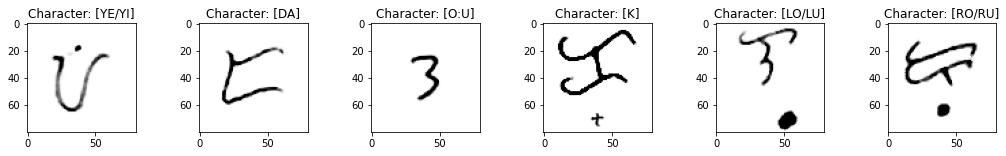

In [17]:
# Inspect list of resized and centered samples
f = plt.figure(figsize=(18,2))
ax = f.subplots(1, 6)
for i, n in enumerate(np.random.choice(list(resized_samples_list.keys()), size=6)):
    m = (np.random.randint(0, len(resized_samples_list[n])))
    ax[i].imshow(resized_samples_list[n][m], cmap='Greys')
    ax[i].set_title(f'Character: [{n}]')
plt.show()

In [18]:
resized_samples_list

{'A': [<PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PIL.Image.Image image mode=L size=80x80>,
  <PI

Image details
Format PNG
Size (56, 47)
Mode L


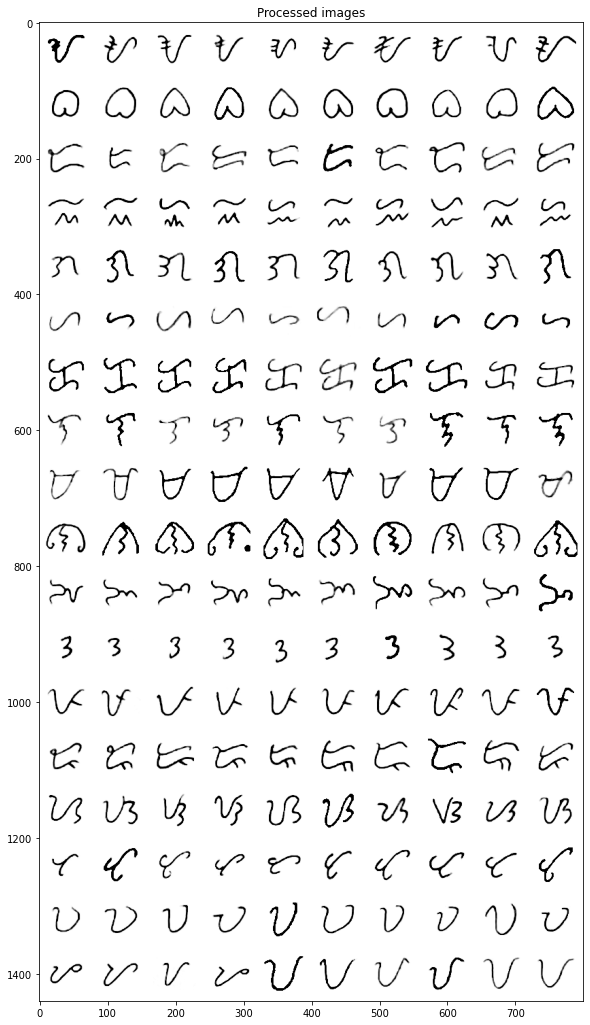

In [19]:
# Make preview
preview = Image.new('L', (10*NEW_SIZE, 18*NEW_SIZE))

x = 0
y = 0
for character in resized_samples_list:
    for i in range(10):
        m = (np.random.randint(0, len(resized_samples_list[character])))
        preview.paste(resized_samples_list[character][m], (x, y))
        x += NEW_SIZE
    y+=NEW_SIZE
    x = 0

show(preview, figsize=(18,18), title='Processed images')
preview.save('preview.png')

___

### Save result

In [20]:
# 6. Save the result in numpy binary format
binary_samples = np.array([[sample.getdata() for sample in resized_samples_list[character][:2652]] for character in resized_samples_list])
binary_samples = binary_samples.reshape(len(resized_samples_list)*2652, NEW_SIZE, NEW_SIZE)

Image details
Format PNG
Size (56, 47)
Mode L


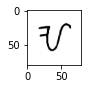

In [21]:
# Here is what it looks like
show(binary_samples[128], figsize=(1,1))

In [22]:
# Create the classes labels
classes = np.array([[i]*2652 for i in new_character_list]).reshape(-1)

In [23]:
classes

array(['A', 'A', 'A', ..., 'Y', 'Y', 'Y'], dtype='<U7')

In [24]:
# 2652 x 18 base characters
print(f'X shape: {binary_samples.shape}')
print(f'y shape: {classes.shape}')

X shape: (167076, 80, 80)
y shape: (167076,)


In [25]:
xfile = 'baybayin_characters_x_test.npy'
yfile = 'baybayin_characters_y_test.npy'
np.save(xfile, binary_samples)
np.save(yfile, classes)

___

### Test if file was saved successfully

In [26]:
# Load the numpy binary files
x_test = np.load(xfile)
y_test = np.load(yfile)
x_test.shape, y_test.shape

((167076, 80, 80), (167076,))

Image details
Format PNG
Size (56, 47)
Mode L


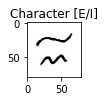

Image details
Format PNG
Size (56, 47)
Mode L


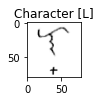

Image details
Format PNG
Size (56, 47)
Mode L


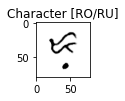

Image details
Format PNG
Size (56, 47)
Mode L


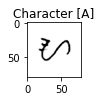

Image details
Format PNG
Size (56, 47)
Mode L


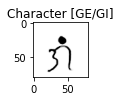

Image details
Format PNG
Size (56, 47)
Mode L


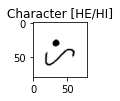

In [27]:
for i in np.random.randint(x_test.shape[0], size=6):
    show(x_test[i], title=f'Character [{y_test[i]}]', figsize=(1,1))

In [ ]:
# Check dataset
num_of_char_per_row = 25

# character = 'YA'
for character in resized_samples_list:
    new_list = [resized_samples_list[character][i:i+num_of_char_per_row] for i in range(0, len(resized_samples_list[character]), num_of_char_per_row)]

    preview = Image.new('L', (num_of_char_per_row*NEW_SIZE, len(new_list)*NEW_SIZE))

    count = 0

    x = 0
    y = 0
    for l in new_list:
        for img in l:
            preview.paste(img, (x, y))
            count+=1
            x += NEW_SIZE
        y+=NEW_SIZE
        x = 0

#     print(f'Total number of characters: {count}')
    
    # creates the directory if not yet present
    preview_path = 'preview'
    os.makedirs(preview_path, exist_ok=True)
    
#     show(preview, figsize=(150,150), title=character)

    if 'E' in character or 'O' in character:
        new_str = character.replace('/',':')
        preview.save(f'preview/{new_str}.png')
    else:
        preview.save(f'preview/{character}.png')